<a href="https://colab.research.google.com/github/santiagoahl/ParserTokenizer/blob/main/proyecto_1_compiladores_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrantes


*   Ahumada Lozano, Santiago
*   Mendez Chipatecua, Eduards Alexis
*   Mora Ramirez, David Felipe 



In [24]:
pip install automata-lib;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 523 kB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


# Repositorio

```
https://github.com/eguar11011/ParserTokenizer.git
```

In [12]:
!git clone https://github.com/DavidFM43/Compilers.git

Cloning into 'Compilers'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 77 (delta 29), reused 56 (delta 13), pack-reused 0
Unpacking objects: 100% (77/77), done.


# Estructura

Para el script **estructura.py** realizamos un parse para el archivo de texto,
con el fin de capturar los tokens y las expresiones regulares, esta información la almacenamos en  una estructura:  `list[Tuple[str, str]]`.

Tal que `str = token` y `str = expresión regular ` respectivamente.
Está estructura la utilizaremos para trabajar de una forma mas facil para poder hacer el tokenizador. La esencia de nuestra solución se basó en la implementación de algoritmos de conversión `regex-GNFA-NFA-DFA`.


# Tokenizador 

In [40]:
from automata.base.automaton import Automaton #Libreria de automatas
from automata.fa.fa import FA #Clase abstracta de automata
from automata.fa.dfa import DFA #Deterministic finite automata
from automata.fa.nfa import NFA #Nondeterministic finite automata
from automata.fa.gnfa import GNFA


In [23]:
%cd automata_toolkit

/content/Compilers/automata-toolkit/Compilers/automata-toolkit/automata_toolkit


In [16]:
%ls

 Automata-Theory-Conversions/   json_specs.txt   Plan.txt
 automata-toolkit/              LICENSE          README.md
'Entrega 1.pdf'                 parteC.ipynb     scanner/


## Expresión regular a forma posfija

En este código se busca representar una expresión regular en forma posfija. La constitución del algoritmo es la siguiente:
```
regex_to_postfix():
Input − Infix regular expression.

Output − Convert infix expression to postfix form.

Begin
   initially push some special character say # into the stack
   for each character ch from infix expression, do
      if ch is alphanumeric character, then
         add ch to postfix expression
      else if ch = opening parenthesis (, then
         push ( into stack
      else if ch = ^, then            //exponential operator of higher precedence
         push ^ into the stack
      else if ch = closing parenthesis ), then
         while stack is not empty and stack top ≠ (,
            do pop and add item from stack to postfix expression
         done

         pop ( also from the stack
      else
         while stack is not empty AND precedence of ch <= precedence of stack top element, do
            pop and add into postfix expression
         done

         push the newly coming character.
   done

   while the stack contains some remaining characters, do
      pop and add to the postfix expression
   done
   return postfix
End
```

Con lo cual, una expresión regular como
```
  (a | b)*
```
Se representa de forma equivalente como:
```
ab|*
```

La ventaja de la anterior conversión consiste en que se puede representar la expresión regular mediante automátas finitos si el algoritmo sabe el orden en el que se llevan a cabo las operaciones sin lugar a ambiguedad.

## Expresión regular a NFA

En este código se implementó un algoritmo capaz de convertir una expresión regular en su equivalente forma de automata finito no determinista. Este algoritmo se basa en el método de descomposición de estados y consiste separar la expresión regular como expresiones fundamentales (unión, estrella de Kleene y concatenación) y despues de ello combinarlas de una manera recursiva hasta poder representar por completo la expresión regular mediante el automáta.
```
Step 1: Take & in; closure for the initial state of NFA as the initial state of DFA.

Step 2: Find the traversable states from the present for each input symbol
(union of the transition value and its closures for each NFA state present in the current DFA state).

Step 3: If any new state is found, take it as the current state and repeat step 2.

Step 4: Repeat Step 2 and Step 3 until no new state is present in the DFA transition table.

Step 5: Mark the DFA states that contain the final NFA state as final DFA states.
```

A continuación un ejemplo de uso con la librería `automaton` de python (Sin embargo el código de este algoritmo se encuentra en nuestro repositorio)

In [41]:
gnfa = GNFA(
    states={'q_in', 'q_f', 'q0', 'q1', 'q2'},
    input_symbols={'a', 'b'},
    transitions={
        'q0': {'q1': 'a', 'q_f': None, 'q2': None, 'q0': None},
        'q1': {'q1': 'a', 'q2': '', 'q_f': '', 'q0': None},
        'q2': {'q0': 'b', 'q_f': None, 'q2': None, 'q1': None},
        'q_in': {'q0': '', 'q_f': None, 'q2': None, 'q1': None}
    },
    initial_state='q_in',
    final_state='q_f'
)

In [43]:
gnfa.show_diagram(path='./gnfa.png', show_None=False)

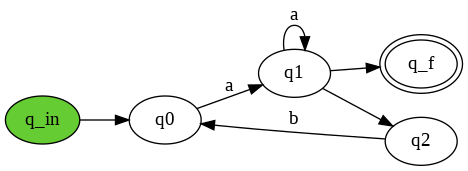

Convirtiendo el automata a DFA:

In [48]:
regex = GNFA.to_regex(gnfa)

In [49]:
nfa = NFA.from_regex(regex)

In [50]:
dfa = DFA.from_nfa(nfa)

In [52]:
dfa.show_diagram(path='./dfa_.png')

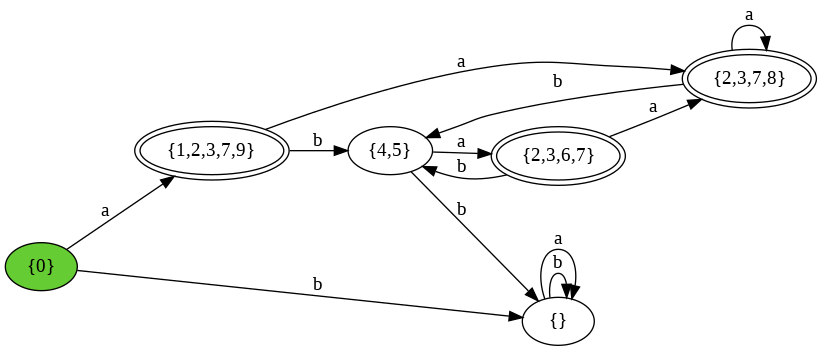

## NFA a DFA
Dado un automata finito no deterministico pretendemos definir un automata finito determinístico equivalente. EL algoritmo que implemetamos se presenta a continuación: 

```
Suppose there is an NFA N <Q, ∑, q0, δ, F> that recognizes a language L. Then the DFA D < Q ', ∑, q0, δ', F '> can be constructed for language L as:
Step 1: Initially Q' = ɸ.
Step 2: Add q0 to Q'.
Step 3: For each state in Q', find the possible set of states for each input symbol using the NFA transition function. If this set of states is not in Q', add it to Q'.
Step 4: The final state of DFA will be all the states that contain F (final states of NFA)
```

Ejemplo: Usando de nuevo la librería `automaton` ilustramos la conversión ya que esta permite visualizar estos automatas. El usuario puede dirigirse a nuestro repositorio para encontrar el algoritmo implementado de manera autónoma.

In [53]:
nfa = NFA(
    states={'q0', 'q1', 'q2', 'q3'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1','q2'}, '1':{'q1'}},
        # Use '' as the key name for empty string (lambda/epsilon) transitions
        'q1': {'1':{'q0'}},
        'q2': {'1': {'q3'}},
        'q3': {'0':{'q0'}}
    },
    initial_state='q0',
    final_states={'q1'}
)

In [59]:
nfa.show_diagram(path='./nfa.png')

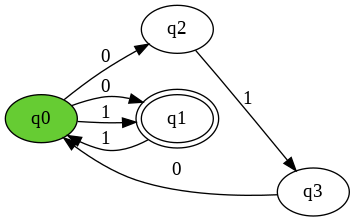

In [54]:
dfa = DFA.from_nfa(nfa)

In [56]:
dfa.show_diagram(path='./dfa_to_nfa.png')

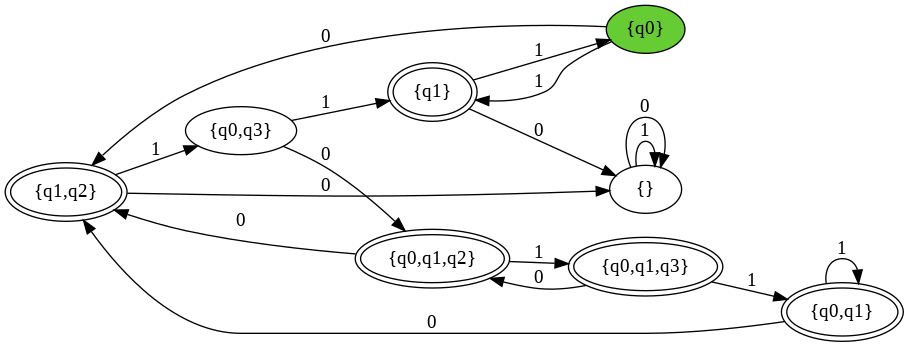

## DFA a expresión regular


In [60]:
dfa = DFA(
    states = {'q0', 'q1', 'q2'},
    input_symbols = {'0', '1'},
    transitions = {
        'q0': {'0': 'q0', '1': 'q1'},
        'q1': {'0': 'q0', '1': 'q2'},
        'q2': {'0': 'q2', '1': 'q1'}
    },
    initial_state = 'q0',
    final_states = {'q1'}
)

In [61]:
dfa.show_diagram(path='./_dfa.png')

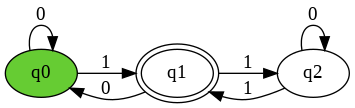

In [62]:
my_nfa = NFA.from_dfa(dfa)

In [64]:
regex = GNFA.from_nfa(my_nfa).to_regex()

In [65]:
print(regex)

0*1(00*1|10*1)*


En este ejemplo la expresión regular equivalente es
```
0*1(00*1|10*1)*
```